In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = [load_array[0][20], load_array[0][50]]
inh = [load_array[1][20], load_array[1][50]]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

file_ = 'up.pickle'

c_var = [0,1]
if len(folder) == 4:
    if folder[3] == 'e':
        p_var = [0]
    elif folder[3] == 'i':
        p_var = [1]
else:
    p_var = [0,1]
    
print(p_var)

step1 = 1
step2 = 10
step3 = 100

/1_ei
[0, 1]


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
d_array = np.arange(20., 300, 0.1)
t0_array = d_array - 20.
t_pen = np.zeros(( t0_array.shape ))
for i in range(len(t_pen)):
    t_pen[i] = t0_array[i] / d_array[i] 

In [8]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

wp = 1./20.

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [1000., -1000., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [6]:
bestControl_ = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_ = np.array( [[None] * len(t_pen)] * len(exc) )
cost_ = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_ = np.array( [[None] * len(t_pen)] * len(exc) )
weights_ = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_ = np.array( [[None] * len(t_pen)] * len(exc) )

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

print(bestControl_.shape)

(2, 2800)


In [208]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [9]:
# get initial parameters and target states
# -------  20 0.4500000000000001 0.4750000000000002
#-------  50 0.47500000000000014 0.6000000000000003

i_range = [0]
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  0 0.4500000000000001 0.4750000000000002


In [10]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    dur = d_array[0]
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen[0])
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  59332.710567880946
RUN  0 , total integrated cost =  59332.710567880946
Gradient descend method:  None
RUN  0 , total integrated cost =  59332.710567880946
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [222]:
bestControl_[1][0] = None

In [11]:
tol = 1e-6

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    cgv = None
    j = 0
    max_it = 1000

    while not convergence_[i][j]:

        dur = d_array[0]
        aln.params.duration = dur
        cost.setParams(wp, 0., 1.)
        weights_[i][j] = [wp, 0., 1.]
        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None) or np.amax(np.abs(bestControl_[i][j])) < 1e-6:
            control0 = aln.getZeroControl()
            if i == 1:
                control0[0,0,1:-1] = 2.
            
        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if max_it > 1:
            if cost_[i][j][2] == 0.:
                convergence_[i][j] = True
                continue

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  2966.6355283940225
RUN  0 , total integrated cost =  2966.6355283940225
Gradient descend method:  None
RUN  1 , total integrated cost =  719.7934322861613
RUN  2 , total integrated cost =  382.4670207888557
RUN  3 , total integrated cost =  312.6416153799241
RUN  4 , total integrated cost =  269.34652988992104
RUN  5 , total integrated cost =  250.04176923468555
RUN  6 , total integrated cost =  238.58169085883694
RUN  7 , total integrated cost =  229.81077244079265
RUN  8 , total integrated cost =  221.76617275663583
RUN  9 , total integrated cost =  215.56192297959234
RUN  10 , total integrated cost =  210.3511761378657
RUN  11 , total integrated cost =  205.87194503096453
RUN  12 , total integrated cost =  201.69614336965213
RUN  13 , total integrated cost =  198.25033793608992
RUN  14 , total integrated cost =  194.65439144728597
RUN  15 , total inte

RUN  700 , total integrated cost =  80.9659060826896
RUN  800 , total integrated cost =  80.93843411842965
RUN  900 , total integrated cost =  80.91651225234338
RUN  1000 , total integrated cost =  80.89751213308088
RUN  1000 , total integrated cost =  80.89751213308088
Improved over  1000  iterations in  41.05775393900694  seconds by  0.48438239404795524  percent.
cost splitting :  [412.50235774 527.6944023 ] [23.99836259  9.88931154]
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  80.89751213308088
RUN  0 , total integrated cost =  80.89751213308088
Gradient descend method:  None
RUN  1 , total integrated cost =  80.89730279594616
RUN  2 , total integrated cost =  80.89710271410738
RUN  3 , total integrated cost =  80.89690145625386
RUN  4 , total integrated cost =  80.89669709650408
RUN  5 , total integrated cost =  80.89650284133134
RUN  6 , total integrated cost =  80.89631825689631
RUN  7 , total integrated cost =  80.89614337507052
RUN  8 , t

RUN  190 , total integrated cost =  80.74847097779434
RUN  200 , total integrated cost =  80.74839063006189
RUN  300 , total integrated cost =  80.74762234349534
RUN  400 , total integrated cost =  80.74696056760237
RUN  500 , total integrated cost =  80.74636418409645
RUN  600 , total integrated cost =  80.74463460022622
RUN  700 , total integrated cost =  80.74314664370259
RUN  800 , total integrated cost =  80.74184644368216
RUN  900 , total integrated cost =  80.74086359033355
RUN  1000 , total integrated cost =  80.74023038352001
RUN  1000 , total integrated cost =  80.74023038352001
Improved over  1000  iterations in  36.11232044201461  seconds by  0.012795685775330412  percent.
cost splitting :  [386.5053406  527.69328716] [25.15118646  9.87911254]
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  80.74023038352001
RUN  0 , total integrated cost =  80.74023038352001
Gradient descend method:  None
RUN  1 , total integrated cost =  80.74022481591

RUN  130 , total integrated cost =  80.73620971732913
RUN  140 , total integrated cost =  80.73620153590775
RUN  150 , total integrated cost =  80.73619309255375
RUN  160 , total integrated cost =  80.73618433600365
RUN  170 , total integrated cost =  80.73617676978773
RUN  180 , total integrated cost =  80.73616935843962
RUN  190 , total integrated cost =  80.73616143050593
RUN  200 , total integrated cost =  80.73615399839957
RUN  300 , total integrated cost =  80.7360829351872
RUN  400 , total integrated cost =  80.73602493816242
RUN  500 , total integrated cost =  80.7359730454329
RUN  600 , total integrated cost =  80.73592759593352
RUN  700 , total integrated cost =  80.73589185207648
RUN  800 , total integrated cost =  80.73586166689677
RUN  900 , total integrated cost =  80.73583412581337
RUN  1000 , total integrated cost =  80.73580982121916
RUN  1000 , total integrated cost =  80.73580982121916
Improved over  1000  iterations in  39.703231752995634  seconds by  0.000647320145

In [12]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1

    while j < 2001:
        
        if convergence_[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(1000)  
        
        cost.setParams(wp, 0., 1.)
        weights_[i][j] = [wp, 0., 1.]

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_[i][j-step][:,:,n_pre-1:-n_post+1]

        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]
            
        weights_[i][j] = cost.getParams()

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_[i][j][-1] == 0.:
            convergence_[i][j] = True
            if j >= 10:
                step = step2
            if j >=100:
                step = step3

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
----- 1
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  51.21696209363839
RUN  0 , total integrated cost =  51.21696209363839
Gradient descend method:  None
RUN  1 , total integrated cost =  51.21696209363839
Control only changes marginally.
RUN  1 , total integrated cost =  51.21696209363839
Improved over  1  iterations in  0.0679350610007532  seconds by  0.0  percent.
cost splitting :  [254.88952206  64.69937449] [25.36008438  9.87743289]
----- 2
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  44.88094909644135
RUN  0 , total integrated cost =  44.88094909644135
Gradient descend method:  None
RUN  1 , total integrated cost =  44.49099931600331
RUN  2 , total integrated cost =  44.323353693497275
RUN  3 , total integrated cost =  44.27628993646923
RUN  4 , total integrated cost =  44.24963938025338
RUN  5 , total integrated cost =  44.22994119223107
RUN  6 , total

RUN  160 , total integrated cost =  38.921977270911746
RUN  170 , total integrated cost =  38.92197646787201
RUN  180 , total integrated cost =  38.921975727632194
RUN  190 , total integrated cost =  38.92197503950569
RUN  200 , total integrated cost =  38.92197435907141
RUN  300 , total integrated cost =  38.92196788667875
RUN  400 , total integrated cost =  38.92196285827743
RUN  500 , total integrated cost =  38.92195878397905
RUN  600 , total integrated cost =  38.921955542580825
RUN  700 , total integrated cost =  38.92195297000072
RUN  800 , total integrated cost =  38.921950890083785
RUN  900 , total integrated cost =  38.92194925755842
RUN  1000 , total integrated cost =  38.92194792072263
RUN  1000 , total integrated cost =  38.92194792072263
Improved over  1000  iterations in  69.71454275702126  seconds by  0.00011406484392750826  percent.
cost splitting :  [128.12288019   3.16587805] [25.35084247  7.00666754]
----- 3
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True

RUN  110 , total integrated cost =  35.2842834310375
RUN  120 , total integrated cost =  35.274468766191376
RUN  130 , total integrated cost =  35.26641178612779
RUN  140 , total integrated cost =  35.26221266490289
RUN  150 , total integrated cost =  35.25916648252399
RUN  160 , total integrated cost =  35.256215277883385
RUN  170 , total integrated cost =  35.2533473292891
RUN  180 , total integrated cost =  35.25073914203972
RUN  190 , total integrated cost =  35.24870461514881
RUN  200 , total integrated cost =  35.2483218971876
RUN  300 , total integrated cost =  35.2443952592797
RUN  400 , total integrated cost =  35.24107570129556
RUN  500 , total integrated cost =  35.23844499477137
RUN  600 , total integrated cost =  35.236193388197826
RUN  700 , total integrated cost =  35.23490318775983
RUN  800 , total integrated cost =  35.23392066564862
RUN  900 , total integrated cost =  35.23291976530208
RUN  1000 , total integrated cost =  35.23217524855908
RUN  1000 , total integrated

RUN  70 , total integrated cost =  32.42183010962731
RUN  80 , total integrated cost =  32.41453289242972
RUN  90 , total integrated cost =  32.40836983362519
RUN  100 , total integrated cost =  32.40283602578021
RUN  110 , total integrated cost =  32.38450033501832
RUN  120 , total integrated cost =  32.37707059372942
RUN  130 , total integrated cost =  32.37040393697327
RUN  140 , total integrated cost =  32.36379309091467
RUN  150 , total integrated cost =  32.359559914677874
RUN  160 , total integrated cost =  32.3558029475951
RUN  170 , total integrated cost =  32.35321208379019
RUN  180 , total integrated cost =  32.35068815153453
RUN  190 , total integrated cost =  32.348211440346404
RUN  200 , total integrated cost =  32.34572588802549
RUN  300 , total integrated cost =  32.32331575411215
RUN  400 , total integrated cost =  32.30593426814525
RUN  500 , total integrated cost =  32.29199823019864
RUN  600 , total integrated cost =  32.281466986681146
RUN  700 , total integrated c

RUN  17 , total integrated cost =  32.23049183101501
RUN  18 , total integrated cost =  32.23049043768916
RUN  19 , total integrated cost =  32.23048903339081
RUN  20 , total integrated cost =  32.23048764590631
RUN  30 , total integrated cost =  32.23047388463691
RUN  40 , total integrated cost =  32.230460444470864
RUN  50 , total integrated cost =  32.23044511235456
RUN  60 , total integrated cost =  32.23043091458073
RUN  70 , total integrated cost =  32.230416885523056
RUN  80 , total integrated cost =  32.23040310431636
RUN  90 , total integrated cost =  32.230390252418445
RUN  100 , total integrated cost =  32.230377693817665
RUN  110 , total integrated cost =  32.23036543452128
RUN  120 , total integrated cost =  32.23035233658783
RUN  130 , total integrated cost =  32.23033992646441
RUN  140 , total integrated cost =  32.23032674929412
RUN  150 , total integrated cost =  32.2303139354175
RUN  160 , total integrated cost =  32.23030139323993
RUN  170 , total integrated cost =  

RUN  18 , total integrated cost =  29.839824689935362
RUN  19 , total integrated cost =  29.839823662321937
RUN  20 , total integrated cost =  29.839822646354282
RUN  30 , total integrated cost =  29.83981259009699
RUN  40 , total integrated cost =  29.839800613816813
RUN  50 , total integrated cost =  29.839790574276897
RUN  60 , total integrated cost =  29.83978075564336
RUN  70 , total integrated cost =  29.839771096391427
RUN  80 , total integrated cost =  29.839761670929914
RUN  90 , total integrated cost =  29.839752549682046
RUN  100 , total integrated cost =  29.839743688392538
RUN  110 , total integrated cost =  29.839735041677685
RUN  120 , total integrated cost =  29.839726604138246
RUN  130 , total integrated cost =  29.839718327198785
RUN  140 , total integrated cost =  29.83971027380698
RUN  150 , total integrated cost =  29.83970240495717
RUN  160 , total integrated cost =  29.83969468234881
RUN  170 , total integrated cost =  29.839687166905208
RUN  180 , total integrat

RUN  9 , total integrated cost =  29.838689016209266
RUN  10 , total integrated cost =  29.838688958360542
RUN  11 , total integrated cost =  29.838688899807558
RUN  12 , total integrated cost =  29.838688838508016
RUN  13 , total integrated cost =  29.8386887836209
RUN  14 , total integrated cost =  29.83868872655357
RUN  15 , total integrated cost =  29.838688668842043
RUN  16 , total integrated cost =  29.83868860836248
RUN  17 , total integrated cost =  29.838688554249135
RUN  18 , total integrated cost =  29.83868849794332
RUN  19 , total integrated cost =  29.838688441040475
RUN  20 , total integrated cost =  29.838688381361308
RUN  30 , total integrated cost =  29.838687830351446
RUN  40 , total integrated cost =  29.838687290512446
RUN  50 , total integrated cost =  29.838686773928988
RUN  60 , total integrated cost =  29.838686267019913
RUN  70 , total integrated cost =  29.838685781345674
RUN  80 , total integrated cost =  29.838685304280343
RUN  90 , total integrated cost = 

RUN  3 , total integrated cost =  29.838640824394005
RUN  4 , total integrated cost =  29.83864082384324
RUN  5 , total integrated cost =  29.838640823274908
RUN  6 , total integrated cost =  29.838640822691367
RUN  7 , total integrated cost =  29.83864082215823
RUN  8 , total integrated cost =  29.838640821613986
RUN  9 , total integrated cost =  29.838640821050614
RUN  10 , total integrated cost =  29.838640820474073
RUN  11 , total integrated cost =  29.838640819945766
RUN  12 , total integrated cost =  29.838640819407964
RUN  13 , total integrated cost =  29.83864081884951
RUN  14 , total integrated cost =  29.838640818279863
RUN  15 , total integrated cost =  29.838640817756353
RUN  16 , total integrated cost =  29.838640817224206
RUN  17 , total integrated cost =  29.838640816678947
RUN  18 , total integrated cost =  29.838640816106935
RUN  19 , total integrated cost =  29.838640815594356
RUN  20 , total integrated cost =  29.838640815061478
RUN  30 , total integrated cost =  29.

RUN  3 , total integrated cost =  27.92225178126503
RUN  4 , total integrated cost =  27.92225054196338
RUN  5 , total integrated cost =  27.922249285401705
RUN  6 , total integrated cost =  27.922247960037996
RUN  7 , total integrated cost =  27.92224679039073
RUN  8 , total integrated cost =  27.922245545355363
RUN  9 , total integrated cost =  27.922244323630057
RUN  10 , total integrated cost =  27.922243148008153
RUN  11 , total integrated cost =  27.922241861895873
RUN  12 , total integrated cost =  27.922240610423277
RUN  13 , total integrated cost =  27.922239421394465
RUN  14 , total integrated cost =  27.922238241602457
RUN  15 , total integrated cost =  27.922236994914595
RUN  16 , total integrated cost =  27.92223573627946
RUN  17 , total integrated cost =  27.922234580139968
RUN  18 , total integrated cost =  27.922233395538154
RUN  19 , total integrated cost =  27.922232188595785
RUN  20 , total integrated cost =  27.92223092205497
RUN  30 , total integrated cost =  27.92

RUN  3 , total integrated cost =  26.37723276467001
RUN  4 , total integrated cost =  26.377203358480447
RUN  5 , total integrated cost =  26.377174182965774
RUN  6 , total integrated cost =  26.37714768542178
RUN  7 , total integrated cost =  26.37712014673052
RUN  8 , total integrated cost =  26.377093037563068
RUN  9 , total integrated cost =  26.377066918980542
RUN  10 , total integrated cost =  26.37703894018739
RUN  11 , total integrated cost =  26.377010963243706
RUN  12 , total integrated cost =  26.376985453402654
RUN  13 , total integrated cost =  26.376958946601786
RUN  14 , total integrated cost =  26.376932684854314
RUN  15 , total integrated cost =  26.37690747489746
RUN  16 , total integrated cost =  26.376880218188013
RUN  17 , total integrated cost =  26.376853179122765
RUN  18 , total integrated cost =  26.376828255946933
RUN  19 , total integrated cost =  26.37680259545338
RUN  20 , total integrated cost =  26.37677689685655
RUN  30 , total integrated cost =  26.3765

RUN  6 , total integrated cost =  25.089393318949583
RUN  7 , total integrated cost =  25.08938841665023
RUN  8 , total integrated cost =  25.08938349919985
RUN  9 , total integrated cost =  25.08937854176313
RUN  10 , total integrated cost =  25.08937351635047
RUN  11 , total integrated cost =  25.08936872358084
RUN  12 , total integrated cost =  25.089363840369682
RUN  13 , total integrated cost =  25.08935899728352
RUN  14 , total integrated cost =  25.089354244076066
RUN  15 , total integrated cost =  25.089349326434018
RUN  16 , total integrated cost =  25.089344475243447
RUN  17 , total integrated cost =  25.089339736525368
RUN  18 , total integrated cost =  25.089335017346265
RUN  19 , total integrated cost =  25.08933021777536
RUN  20 , total integrated cost =  25.089325396496292
RUN  30 , total integrated cost =  25.089279011642315
RUN  40 , total integrated cost =  25.08923427075273
RUN  50 , total integrated cost =  25.089191245583006
RUN  60 , total integrated cost =  25.08

RUN  4 , total integrated cost =  25.08635850779598
RUN  5 , total integrated cost =  25.0863584975417
RUN  6 , total integrated cost =  25.086358488374735
RUN  7 , total integrated cost =  25.08635847920075
RUN  8 , total integrated cost =  25.086358469111623
RUN  9 , total integrated cost =  25.08635845919479
RUN  10 , total integrated cost =  25.08635845002229
RUN  11 , total integrated cost =  25.0863584405215
RUN  12 , total integrated cost =  25.08635843110303
RUN  13 , total integrated cost =  25.086358421979888
RUN  14 , total integrated cost =  25.086358412267934
RUN  15 , total integrated cost =  25.08635840238125
RUN  16 , total integrated cost =  25.08635839349344
RUN  17 , total integrated cost =  25.086358384596533
RUN  18 , total integrated cost =  25.08635837386552
RUN  19 , total integrated cost =  25.08635836300618
RUN  20 , total integrated cost =  25.08635834742557
RUN  30 , total integrated cost =  25.08635803042731
RUN  40 , total integrated cost =  25.08635789603

RUN  5 , total integrated cost =  24.460897934883064
RUN  6 , total integrated cost =  24.45397362458046
RUN  7 , total integrated cost =  24.447392756840657
RUN  8 , total integrated cost =  24.441964603930188
RUN  9 , total integrated cost =  24.436660786557194
RUN  10 , total integrated cost =  24.43163398147473
RUN  11 , total integrated cost =  24.42698857357663
RUN  12 , total integrated cost =  24.423038313488185
RUN  13 , total integrated cost =  24.41918403798789
RUN  14 , total integrated cost =  24.41537987357957
RUN  15 , total integrated cost =  24.411335478572013
RUN  16 , total integrated cost =  24.407620082813644
RUN  17 , total integrated cost =  24.40170100677175
RUN  18 , total integrated cost =  24.396635127759904
RUN  19 , total integrated cost =  24.384301600288964
RUN  20 , total integrated cost =  24.373343179941415
RUN  30 , total integrated cost =  24.306487742553674
RUN  40 , total integrated cost =  24.283521321239135
RUN  50 , total integrated cost =  24.2

RUN  3 , total integrated cost =  24.00954791220529
RUN  4 , total integrated cost =  24.009547605529143
RUN  5 , total integrated cost =  24.00954728852373
RUN  6 , total integrated cost =  24.009546953458138
RUN  7 , total integrated cost =  24.009546625291566
RUN  8 , total integrated cost =  24.009546314669514
RUN  9 , total integrated cost =  24.00954602465706
RUN  10 , total integrated cost =  24.00954572571974
RUN  11 , total integrated cost =  24.009545434620073
RUN  12 , total integrated cost =  24.009545146514178
RUN  13 , total integrated cost =  24.009544854438932
RUN  14 , total integrated cost =  24.009544576390986
RUN  15 , total integrated cost =  24.009544281817913
RUN  16 , total integrated cost =  24.00954397905286
RUN  17 , total integrated cost =  24.009543714100833
RUN  18 , total integrated cost =  24.009543456947892
RUN  19 , total integrated cost =  24.009543204392862
RUN  20 , total integrated cost =  24.009542954372577
RUN  30 , total integrated cost =  24.00

RUN  9 , total integrated cost =  18.48685110073691
RUN  10 , total integrated cost =  18.486839600597033
RUN  11 , total integrated cost =  18.48682705421548
RUN  12 , total integrated cost =  18.486809794878
RUN  13 , total integrated cost =  18.48679694476287
RUN  14 , total integrated cost =  18.48678487455928
RUN  15 , total integrated cost =  18.48677292719001
RUN  16 , total integrated cost =  18.48676153968132
RUN  17 , total integrated cost =  18.486750011239526
RUN  18 , total integrated cost =  18.48673824938492
RUN  19 , total integrated cost =  18.48672667978051
RUN  20 , total integrated cost =  18.48671530112663
RUN  30 , total integrated cost =  18.486600352945896
RUN  40 , total integrated cost =  18.486492304732128
RUN  50 , total integrated cost =  18.486383697185527
RUN  60 , total integrated cost =  18.486283367442812
RUN  70 , total integrated cost =  18.486178050550823
RUN  80 , total integrated cost =  18.486071583133548
RUN  90 , total integrated cost =  18.485

RUN  5 , total integrated cost =  18.483273083601333
RUN  6 , total integrated cost =  18.48327308349148
RUN  7 , total integrated cost =  18.4832730833824
RUN  8 , total integrated cost =  18.483273083272355
RUN  9 , total integrated cost =  18.483273083165624
RUN  10 , total integrated cost =  18.483273083059785
RUN  11 , total integrated cost =  18.483273082951506
RUN  12 , total integrated cost =  18.483273082845628
RUN  13 , total integrated cost =  18.483273082740283
RUN  14 , total integrated cost =  18.483273082634227
RUN  15 , total integrated cost =  18.48327308253121
RUN  16 , total integrated cost =  18.48327308242918
RUN  17 , total integrated cost =  18.48327308232461
RUN  18 , total integrated cost =  18.483273082222546
RUN  19 , total integrated cost =  18.483273082120814
RUN  20 , total integrated cost =  18.483273082018577
RUN  30 , total integrated cost =  18.48327308104907
RUN  40 , total integrated cost =  18.483273080135422
RUN  50 , total integrated cost =  18.48

RUN  12 , total integrated cost =  16.208971286898347
RUN  13 , total integrated cost =  16.208969407493854
RUN  14 , total integrated cost =  16.2089677047827
RUN  15 , total integrated cost =  16.208966092337178
RUN  16 , total integrated cost =  16.20896452891237
RUN  17 , total integrated cost =  16.208963058865884
RUN  18 , total integrated cost =  16.208961556348015
RUN  19 , total integrated cost =  16.20896010812053
RUN  20 , total integrated cost =  16.20895875379573
RUN  30 , total integrated cost =  16.208937815007797
RUN  40 , total integrated cost =  16.20890521424357
RUN  50 , total integrated cost =  16.208877394552673
RUN  60 , total integrated cost =  16.208862733124807
RUN  70 , total integrated cost =  16.20883936238945
RUN  80 , total integrated cost =  16.208826310568295
RUN  90 , total integrated cost =  16.208814142740653
RUN  100 , total integrated cost =  16.208792721238062
RUN  110 , total integrated cost =  16.208769463298836
RUN  120 , total integrated cost 

RUN  10 , total integrated cost =  14.808271877755205
RUN  11 , total integrated cost =  14.808268796820881
RUN  12 , total integrated cost =  14.808266709480833
RUN  13 , total integrated cost =  14.808264893019324
RUN  14 , total integrated cost =  14.808263369993147
RUN  15 , total integrated cost =  14.808261903159078
RUN  16 , total integrated cost =  14.808260592479146
RUN  17 , total integrated cost =  14.808259323476848
RUN  18 , total integrated cost =  14.808258157632542
RUN  19 , total integrated cost =  14.808256955971649
RUN  20 , total integrated cost =  14.808255825632747
RUN  30 , total integrated cost =  14.808238258928228
RUN  40 , total integrated cost =  14.808218844254123
RUN  50 , total integrated cost =  14.808205429645021
RUN  60 , total integrated cost =  14.808182338366471
RUN  70 , total integrated cost =  14.808172493439
RUN  80 , total integrated cost =  14.808157169847322
RUN  90 , total integrated cost =  14.808142603288497
RUN  100 , total integrated cos

RUN  10 , total integrated cost =  13.709148274670861
RUN  11 , total integrated cost =  13.709132366455703
RUN  12 , total integrated cost =  13.709123510597495
RUN  13 , total integrated cost =  13.709115187592337
RUN  14 , total integrated cost =  13.709108711201385
RUN  15 , total integrated cost =  13.70910125453249
RUN  16 , total integrated cost =  13.709092356544252
RUN  17 , total integrated cost =  13.709076061369602
RUN  18 , total integrated cost =  13.709067407436883
RUN  19 , total integrated cost =  13.709060189670383
RUN  20 , total integrated cost =  13.709053930784567
RUN  30 , total integrated cost =  13.708964226180433
RUN  40 , total integrated cost =  13.708892065714283
RUN  50 , total integrated cost =  13.70872950525883
RUN  60 , total integrated cost =  13.70867266197318
RUN  70 , total integrated cost =  13.708611153323515
RUN  80 , total integrated cost =  13.708550952086641
RUN  90 , total integrated cost =  13.708494033781266
RUN  100 , total integrated cos

RUN  4 , total integrated cost =  12.712305367889297
RUN  5 , total integrated cost =  12.712283737498721
RUN  6 , total integrated cost =  12.712260886937308
RUN  7 , total integrated cost =  12.71223901259971
RUN  8 , total integrated cost =  12.71221644613565
RUN  9 , total integrated cost =  12.712194632750357
RUN  10 , total integrated cost =  12.712171868411962
RUN  11 , total integrated cost =  12.712149293031734
RUN  12 , total integrated cost =  12.712127108298773
RUN  13 , total integrated cost =  12.712105025715278
RUN  14 , total integrated cost =  12.712082716001131
RUN  15 , total integrated cost =  12.71206005958559
RUN  16 , total integrated cost =  12.712037430953062
RUN  17 , total integrated cost =  12.712013889787334
RUN  18 , total integrated cost =  12.71199165001919
RUN  19 , total integrated cost =  12.711968955412884
RUN  20 , total integrated cost =  12.711946402322475
RUN  30 , total integrated cost =  12.711723492579612
RUN  40 , total integrated cost =  12.

RUN  3 , total integrated cost =  12.532378674940615
RUN  4 , total integrated cost =  12.517449886664874
RUN  5 , total integrated cost =  12.503467260378365
RUN  6 , total integrated cost =  12.490155373677107
RUN  7 , total integrated cost =  12.47781563415119
RUN  8 , total integrated cost =  12.466204350157126
RUN  9 , total integrated cost =  12.45430892435327
RUN  10 , total integrated cost =  12.442462683550383
RUN  11 , total integrated cost =  12.428425634195577
RUN  12 , total integrated cost =  12.41586586764226
RUN  13 , total integrated cost =  12.403900546784826
RUN  14 , total integrated cost =  12.392546980457743
RUN  15 , total integrated cost =  12.37963195954773
RUN  16 , total integrated cost =  12.368838951872505
RUN  17 , total integrated cost =  12.356983462278654
RUN  18 , total integrated cost =  12.34588930469204
RUN  19 , total integrated cost =  12.33453818085018
RUN  20 , total integrated cost =  12.32484671265975
RUN  30 , total integrated cost =  12.2457

RUN  3 , total integrated cost =  11.554504878731306
RUN  4 , total integrated cost =  11.538813910087168
RUN  5 , total integrated cost =  11.526291107766047
RUN  6 , total integrated cost =  11.514414414688655
RUN  7 , total integrated cost =  11.503090433691659
RUN  8 , total integrated cost =  11.49194172576073
RUN  9 , total integrated cost =  11.48180556904959
RUN  10 , total integrated cost =  11.472149459584363
RUN  11 , total integrated cost =  11.462621255070617
RUN  12 , total integrated cost =  11.452798994348758
RUN  13 , total integrated cost =  11.44366992319669
RUN  14 , total integrated cost =  11.434965004136876
RUN  15 , total integrated cost =  11.426849613342394
RUN  16 , total integrated cost =  11.41947462682251
RUN  17 , total integrated cost =  11.412155242620935
RUN  18 , total integrated cost =  11.405164027647878
RUN  19 , total integrated cost =  11.396354233537632
RUN  20 , total integrated cost =  11.388654727136435
RUN  30 , total integrated cost =  11.3

RUN  4 , total integrated cost =  10.885816824524394
RUN  5 , total integrated cost =  10.885812890985518
RUN  6 , total integrated cost =  10.885811212850129
RUN  7 , total integrated cost =  10.885810730388437
RUN  8 , total integrated cost =  10.885810388661213
RUN  9 , total integrated cost =  10.88581017976448
RUN  10 , total integrated cost =  10.885809903455248
RUN  11 , total integrated cost =  10.885809679410047
RUN  12 , total integrated cost =  10.885804390726902
RUN  13 , total integrated cost =  10.885802910756007
RUN  14 , total integrated cost =  10.885802376651245
RUN  15 , total integrated cost =  10.885802144586572
RUN  16 , total integrated cost =  10.885801882928709
RUN  17 , total integrated cost =  10.885801714759554
RUN  18 , total integrated cost =  10.885801474955285
RUN  19 , total integrated cost =  10.885801314642134
RUN  20 , total integrated cost =  10.885801015388662
RUN  30 , total integrated cost =  10.885783776676139
RUN  40 , total integrated cost =  

RUN  8 , total integrated cost =  9.85238672580451
RUN  9 , total integrated cost =  9.840553397417331
RUN  10 , total integrated cost =  9.829662966239262
RUN  11 , total integrated cost =  9.820197604612073
RUN  12 , total integrated cost =  9.81179066321633
RUN  13 , total integrated cost =  9.803535723197559
RUN  14 , total integrated cost =  9.794872436145988
RUN  15 , total integrated cost =  9.785868061371582
RUN  16 , total integrated cost =  9.777117864878095
RUN  17 , total integrated cost =  9.767463309743558
RUN  18 , total integrated cost =  9.757644381030685
RUN  19 , total integrated cost =  9.74375526034667
RUN  20 , total integrated cost =  9.730375470470168
RUN  30 , total integrated cost =  9.634675919115036
RUN  40 , total integrated cost =  9.584841236472
RUN  50 , total integrated cost =  9.539548440488826
RUN  60 , total integrated cost =  9.505121376000012
RUN  70 , total integrated cost =  9.461675574690775
RUN  80 , total integrated cost =  9.425962274507505
R

RUN  3 , total integrated cost =  8.975133538896591
RUN  4 , total integrated cost =  8.975120475075538
RUN  5 , total integrated cost =  8.975107895042118
RUN  6 , total integrated cost =  8.975094829775315
RUN  7 , total integrated cost =  8.975082638016124
RUN  8 , total integrated cost =  8.975069742907902
RUN  9 , total integrated cost =  8.975057644370636
RUN  10 , total integrated cost =  8.975044801619685
RUN  11 , total integrated cost =  8.97503166016222
RUN  12 , total integrated cost =  8.975017518419223
RUN  13 , total integrated cost =  8.975006174013838
RUN  14 , total integrated cost =  8.97499394171656
RUN  15 , total integrated cost =  8.974980943564159
RUN  16 , total integrated cost =  8.974969205177848
RUN  17 , total integrated cost =  8.97495727414913
RUN  18 , total integrated cost =  8.974945345941599
RUN  19 , total integrated cost =  8.974932550109155
RUN  20 , total integrated cost =  8.974919743123387
RUN  30 , total integrated cost =  8.974797629354567
RUN

RUN  7 , total integrated cost =  7.861337043284042
RUN  8 , total integrated cost =  7.848444224156098
RUN  9 , total integrated cost =  7.835556744721066
RUN  10 , total integrated cost =  7.822657674021671
RUN  11 , total integrated cost =  7.809414359119749
RUN  12 , total integrated cost =  7.796290765624582
RUN  13 , total integrated cost =  7.7841855434337965
RUN  14 , total integrated cost =  7.772039726946984
RUN  15 , total integrated cost =  7.759896262434252
RUN  16 , total integrated cost =  7.748103379424383
RUN  17 , total integrated cost =  7.736617139687235
RUN  18 , total integrated cost =  7.725425504808141
RUN  19 , total integrated cost =  7.714009856294796
RUN  20 , total integrated cost =  7.702875611940043
RUN  30 , total integrated cost =  7.605975078255268
RUN  40 , total integrated cost =  7.521938289589524
RUN  50 , total integrated cost =  7.441418001595553
RUN  60 , total integrated cost =  7.373574704032099
RUN  70 , total integrated cost =  7.31678739667

RUN  4 , total integrated cost =  5.888658018460951
RUN  5 , total integrated cost =  5.888651935207658
RUN  6 , total integrated cost =  5.888646494576321
RUN  7 , total integrated cost =  5.888640456023963
RUN  8 , total integrated cost =  5.888634991529367
RUN  9 , total integrated cost =  5.888629025273028
RUN  10 , total integrated cost =  5.888623468624479
RUN  11 , total integrated cost =  5.888617570783099
RUN  12 , total integrated cost =  5.888611912868684
RUN  13 , total integrated cost =  5.8886060697547356
RUN  14 , total integrated cost =  5.88860036563
RUN  15 , total integrated cost =  5.8885946273988985
RUN  16 , total integrated cost =  5.888589174113239
RUN  17 , total integrated cost =  5.888584117910952
RUN  18 , total integrated cost =  5.888578520773912
RUN  19 , total integrated cost =  5.888573078968879
RUN  20 , total integrated cost =  5.8885680101709905
RUN  30 , total integrated cost =  5.8885129847911
RUN  40 , total integrated cost =  5.88845571924553
RUN

RUN  3 , total integrated cost =  5.862231836868171
RUN  4 , total integrated cost =  5.8622189362813035
RUN  5 , total integrated cost =  5.862200468525921
RUN  6 , total integrated cost =  5.86218740390767
RUN  7 , total integrated cost =  5.862167910143594
RUN  8 , total integrated cost =  5.8621540154862695
RUN  9 , total integrated cost =  5.862135381208885
RUN  10 , total integrated cost =  5.862121055489306
RUN  11 , total integrated cost =  5.862099443396019
RUN  12 , total integrated cost =  5.862085851722942
RUN  13 , total integrated cost =  5.862071045936943
RUN  14 , total integrated cost =  5.8620587347753945
RUN  15 , total integrated cost =  5.86204389311142
RUN  16 , total integrated cost =  5.862031698639678
RUN  17 , total integrated cost =  5.862016853576839
RUN  18 , total integrated cost =  5.862004673980599
RUN  19 , total integrated cost =  5.861989828220518
RUN  20 , total integrated cost =  5.861978865742422
RUN  30 , total integrated cost =  5.861842931149253

RUN  4 , total integrated cost =  5.730189450141454
RUN  5 , total integrated cost =  5.730096205491451
RUN  6 , total integrated cost =  5.7300056728839275
RUN  7 , total integrated cost =  5.729911590224678
RUN  8 , total integrated cost =  5.729821654521627
RUN  9 , total integrated cost =  5.729728569476093
RUN  10 , total integrated cost =  5.72963744106065
RUN  11 , total integrated cost =  5.729544354496253
RUN  12 , total integrated cost =  5.729453045353095
RUN  13 , total integrated cost =  5.729360022694202
RUN  14 , total integrated cost =  5.729268492844909
RUN  15 , total integrated cost =  5.729175509877523
RUN  16 , total integrated cost =  5.729083792836262
RUN  17 , total integrated cost =  5.72899002273534
RUN  18 , total integrated cost =  5.728898907755812
RUN  19 , total integrated cost =  5.728805945076467
RUN  20 , total integrated cost =  5.728713942799918
RUN  30 , total integrated cost =  5.727787798760461
RUN  40 , total integrated cost =  5.726857694794356


RUN  4 , total integrated cost =  5.401622009429773
RUN  5 , total integrated cost =  5.401541022672696
RUN  6 , total integrated cost =  5.401456276785012
RUN  7 , total integrated cost =  5.401375049247455
RUN  8 , total integrated cost =  5.401290224412796
RUN  9 , total integrated cost =  5.401208813225739
RUN  10 , total integrated cost =  5.401123970452781
RUN  11 , total integrated cost =  5.401042529766676
RUN  12 , total integrated cost =  5.4009576685842315
RUN  13 , total integrated cost =  5.400876356950599
RUN  14 , total integrated cost =  5.400791483375895
RUN  15 , total integrated cost =  5.400710426328661
RUN  16 , total integrated cost =  5.400625607590357
RUN  17 , total integrated cost =  5.400545033199657
RUN  18 , total integrated cost =  5.400460307273537
RUN  19 , total integrated cost =  5.400380340651458
RUN  20 , total integrated cost =  5.400295816654549
RUN  30 , total integrated cost =  5.399280020290045
RUN  40 , total integrated cost =  5.39835987720125

RUN  4 , total integrated cost =  5.21198912264304
RUN  5 , total integrated cost =  5.2119524582803685
RUN  6 , total integrated cost =  5.211911505879677
RUN  7 , total integrated cost =  5.211878144736532
RUN  8 , total integrated cost =  5.211843632448533
RUN  9 , total integrated cost =  5.211813993369254
RUN  10 , total integrated cost =  5.2117862567534035
RUN  11 , total integrated cost =  5.211758153751671
RUN  12 , total integrated cost =  5.211730308439924
RUN  13 , total integrated cost =  5.21169990335721
RUN  14 , total integrated cost =  5.211640668260108
RUN  15 , total integrated cost =  5.211593675130281
RUN  16 , total integrated cost =  5.211539251543504
RUN  17 , total integrated cost =  5.211487813144218
RUN  18 , total integrated cost =  5.211445899909381
RUN  19 , total integrated cost =  5.211410767423959
RUN  20 , total integrated cost =  5.21138136040138
RUN  30 , total integrated cost =  5.210995145155913
RUN  40 , total integrated cost =  5.210652414221941


RUN  5 , total integrated cost =  5.152677101682033
RUN  6 , total integrated cost =  5.1526673465852895
RUN  7 , total integrated cost =  5.1526584124179395
RUN  8 , total integrated cost =  5.152648636046279
RUN  9 , total integrated cost =  5.152639729651555
RUN  10 , total integrated cost =  5.152629948623184
RUN  11 , total integrated cost =  5.152621075558052
RUN  12 , total integrated cost =  5.152611308615411
RUN  13 , total integrated cost =  5.152602499854338
RUN  14 , total integrated cost =  5.1525927731483465
RUN  15 , total integrated cost =  5.152583965565831
RUN  16 , total integrated cost =  5.152574274119296
RUN  17 , total integrated cost =  5.152565469610038
RUN  18 , total integrated cost =  5.152555811461663
RUN  19 , total integrated cost =  5.1525470119670675
RUN  20 , total integrated cost =  5.1525373854954335
RUN  30 , total integrated cost =  5.152447854638405
RUN  40 , total integrated cost =  5.152357469613144
RUN  50 , total integrated cost =  5.152271740

RUN  4 , total integrated cost =  5.1402968951733214
RUN  5 , total integrated cost =  5.140295351273399
RUN  6 , total integrated cost =  5.140293767737991
RUN  7 , total integrated cost =  5.1402922259200805
RUN  8 , total integrated cost =  5.14029064434163
RUN  9 , total integrated cost =  5.140289104440279
RUN  10 , total integrated cost =  5.14028752519512
RUN  11 , total integrated cost =  5.140285987088386
RUN  12 , total integrated cost =  5.140284478300655
RUN  13 , total integrated cost =  5.1402829076103576
RUN  14 , total integrated cost =  5.140281355751422
RUN  15 , total integrated cost =  5.140279830407165
RUN  16 , total integrated cost =  5.140278323867116
RUN  17 , total integrated cost =  5.140276759428204
RUN  18 , total integrated cost =  5.14027520954057
RUN  19 , total integrated cost =  5.140273690719183
RUN  20 , total integrated cost =  5.1402721876837685
RUN  30 , total integrated cost =  5.140257043561292
RUN  40 , total integrated cost =  5.14024210609341

RUN  4 , total integrated cost =  5.137369765262623
RUN  5 , total integrated cost =  5.137369537949272
RUN  6 , total integrated cost =  5.137369336033944
RUN  7 , total integrated cost =  5.137369101623735
RUN  8 , total integrated cost =  5.1373688564823725
RUN  9 , total integrated cost =  5.137368634183848
RUN  10 , total integrated cost =  5.137368431180003
RUN  11 , total integrated cost =  5.137368196755694
RUN  12 , total integrated cost =  5.137367959534173
RUN  13 , total integrated cost =  5.137367731873397
RUN  14 , total integrated cost =  5.137367536691797
RUN  15 , total integrated cost =  5.13736730214713
RUN  16 , total integrated cost =  5.137367058948342
RUN  17 , total integrated cost =  5.137366821114075
RUN  18 , total integrated cost =  5.1373665376488376
RUN  19 , total integrated cost =  5.137366310338364
RUN  20 , total integrated cost =  5.137366117730931
RUN  30 , total integrated cost =  5.1373638159780235
RUN  40 , total integrated cost =  5.1373614900254

RUN  3 , total integrated cost =  4.253345882598903
RUN  4 , total integrated cost =  4.253332984663667
RUN  5 , total integrated cost =  4.253319918260474
RUN  6 , total integrated cost =  4.25330511376149
RUN  7 , total integrated cost =  4.253291088511257
RUN  8 , total integrated cost =  4.253277509053726
RUN  9 , total integrated cost =  4.253263012204069
RUN  10 , total integrated cost =  4.253247029746684
RUN  11 , total integrated cost =  4.253230050253846
RUN  12 , total integrated cost =  4.253216180988835
RUN  13 , total integrated cost =  4.253202350195716
RUN  14 , total integrated cost =  4.253186224854085
RUN  15 , total integrated cost =  4.253168694244457
RUN  16 , total integrated cost =  4.253155138881281
RUN  17 , total integrated cost =  4.253141291602541
RUN  18 , total integrated cost =  4.253125504140432
RUN  19 , total integrated cost =  4.2531092168607065
RUN  20 , total integrated cost =  4.253095353004615
RUN  30 , total integrated cost =  4.252946448597851


RUN  4 , total integrated cost =  4.219434448825461
RUN  5 , total integrated cost =  4.219434244743691
RUN  6 , total integrated cost =  4.219434123529795
RUN  7 , total integrated cost =  4.219433981766579
RUN  8 , total integrated cost =  4.219433876054155
RUN  9 , total integrated cost =  4.219433747119706
RUN  10 , total integrated cost =  4.219433639741812
RUN  11 , total integrated cost =  4.2194335085213135
RUN  12 , total integrated cost =  4.219433393179411
RUN  13 , total integrated cost =  4.219433243897478
RUN  14 , total integrated cost =  4.2194331110970795
RUN  15 , total integrated cost =  4.219432952687862
RUN  16 , total integrated cost =  4.219432811783379
RUN  17 , total integrated cost =  4.219432667486932
RUN  18 , total integrated cost =  4.219432538915898
RUN  19 , total integrated cost =  4.219432384360754
RUN  20 , total integrated cost =  4.219432227226593
RUN  30 , total integrated cost =  4.219430878780621
RUN  40 , total integrated cost =  4.2194297540438

RUN  4 , total integrated cost =  3.9487285779608987
RUN  5 , total integrated cost =  3.94872825396575
RUN  6 , total integrated cost =  3.9487279326792524
RUN  7 , total integrated cost =  3.948727617040123
RUN  8 , total integrated cost =  3.948727301901625
RUN  9 , total integrated cost =  3.9487269988025826
RUN  10 , total integrated cost =  3.948726672174793
RUN  11 , total integrated cost =  3.948726350080364
RUN  12 , total integrated cost =  3.948726020581743
RUN  13 , total integrated cost =  3.9487256457067685
RUN  14 , total integrated cost =  3.9487253143757166
RUN  15 , total integrated cost =  3.9487249693253803
RUN  16 , total integrated cost =  3.94872479447258
RUN  17 , total integrated cost =  3.9487246021636904
RUN  18 , total integrated cost =  3.9487244761305784
RUN  19 , total integrated cost =  3.9487243147431705
RUN  20 , total integrated cost =  3.948724189430544
RUN  30 , total integrated cost =  3.9486984530714633
RUN  40 , total integrated cost =  3.9486895

RUN  8 , total integrated cost =  3.6024862521637626
RUN  9 , total integrated cost =  3.601957417341714
RUN  10 , total integrated cost =  3.6015420277161088
RUN  11 , total integrated cost =  3.6011474422083447
RUN  12 , total integrated cost =  3.6007828619134603
RUN  13 , total integrated cost =  3.6004616646313776
RUN  14 , total integrated cost =  3.6001802740025126
RUN  15 , total integrated cost =  3.5998950047256972
RUN  16 , total integrated cost =  3.5996498525745997
RUN  17 , total integrated cost =  3.599420177468235
RUN  18 , total integrated cost =  3.5992162699249346
RUN  19 , total integrated cost =  3.5990218414045496
RUN  20 , total integrated cost =  3.5988490161248317
RUN  30 , total integrated cost =  3.5975119106382047
RUN  40 , total integrated cost =  3.596626924828542
RUN  50 , total integrated cost =  3.595971618594426
RUN  60 , total integrated cost =  3.5954124645297747
RUN  70 , total integrated cost =  3.5949230997446278
RUN  80 , total integrated cost = 

RUN  7 , total integrated cost =  3.5075016535088444
RUN  8 , total integrated cost =  3.5071539594893473
RUN  9 , total integrated cost =  3.5068614476125846
RUN  10 , total integrated cost =  3.506608795209939
RUN  11 , total integrated cost =  3.5063933910725344
RUN  12 , total integrated cost =  3.5061988689115107
RUN  13 , total integrated cost =  3.506025677440266
RUN  14 , total integrated cost =  3.5058724194960464
RUN  15 , total integrated cost =  3.505745704432651
RUN  16 , total integrated cost =  3.5056239400586287
RUN  17 , total integrated cost =  3.505518982705577
RUN  18 , total integrated cost =  3.50541513510294
RUN  19 , total integrated cost =  3.5053206679672226
RUN  20 , total integrated cost =  3.505230353639706
RUN  30 , total integrated cost =  3.5045736144896398
RUN  40 , total integrated cost =  3.5040826064521218
RUN  50 , total integrated cost =  3.5034836967049245
RUN  60 , total integrated cost =  3.502193262546673
RUN  70 , total integrated cost =  3.50

RUN  3 , total integrated cost =  3.4357459867726816
RUN  4 , total integrated cost =  3.435744001801781
RUN  5 , total integrated cost =  3.4357420956110998
RUN  6 , total integrated cost =  3.4357403144527994
RUN  7 , total integrated cost =  3.4357384751826916
RUN  8 , total integrated cost =  3.4357366700056615
RUN  9 , total integrated cost =  3.4357348981735787
RUN  10 , total integrated cost =  3.4357330854879367
RUN  11 , total integrated cost =  3.435731179744568
RUN  12 , total integrated cost =  3.4357295251405047
RUN  13 , total integrated cost =  3.4357279279607886
RUN  14 , total integrated cost =  3.435726090736105
RUN  15 , total integrated cost =  3.4357243637742583
RUN  16 , total integrated cost =  3.4357226193346526
RUN  17 , total integrated cost =  3.435720860220658
RUN  18 , total integrated cost =  3.4357191070220816
RUN  19 , total integrated cost =  3.435717401432037
RUN  20 , total integrated cost =  3.435715624693052
RUN  30 , total integrated cost =  3.4356

RUN  6 , total integrated cost =  3.3813382268150582
RUN  7 , total integrated cost =  3.381314386843071
RUN  8 , total integrated cost =  3.3812921222208296
RUN  9 , total integrated cost =  3.3812704151011697
RUN  10 , total integrated cost =  3.3812485265983785
RUN  11 , total integrated cost =  3.381226480056636
RUN  12 , total integrated cost =  3.381207231473211
RUN  13 , total integrated cost =  3.381188428619693
RUN  14 , total integrated cost =  3.3811629669418126
RUN  15 , total integrated cost =  3.3811393206622764
RUN  16 , total integrated cost =  3.381124887068012
RUN  17 , total integrated cost =  3.3811105500872394
RUN  18 , total integrated cost =  3.3810991608251877
RUN  19 , total integrated cost =  3.3810875680813632
RUN  20 , total integrated cost =  3.3810720906824825
RUN  30 , total integrated cost =  3.380924282120347
RUN  40 , total integrated cost =  3.3804321293749755
RUN  50 , total integrated cost =  3.380336283345348
RUN  60 , total integrated cost =  3.38

RUN  2 , total integrated cost =  3.3656490975629834
RUN  3 , total integrated cost =  3.365585973720659
RUN  4 , total integrated cost =  3.365527127664154
RUN  5 , total integrated cost =  3.365484213003974
RUN  6 , total integrated cost =  3.3654391742121263
RUN  7 , total integrated cost =  3.3654052668281222
RUN  8 , total integrated cost =  3.365374668322146
RUN  9 , total integrated cost =  3.365351862806421
RUN  10 , total integrated cost =  3.3653310077604766
RUN  11 , total integrated cost =  3.365314474986991
RUN  12 , total integrated cost =  3.365300717829263
RUN  13 , total integrated cost =  3.3652887474277455
RUN  14 , total integrated cost =  3.3652776418528325
RUN  15 , total integrated cost =  3.365268716256658
RUN  16 , total integrated cost =  3.365259825037621
RUN  17 , total integrated cost =  3.3652524708475817
RUN  18 , total integrated cost =  3.365245132260705
RUN  19 , total integrated cost =  3.3652386992584202
RUN  20 , total integrated cost =  3.365232129

RUN  2 , total integrated cost =  3.3555182638216627
RUN  3 , total integrated cost =  3.3554980445386744
RUN  4 , total integrated cost =  3.3554770968575127
RUN  5 , total integrated cost =  3.355459994847755
RUN  6 , total integrated cost =  3.355442565942032
RUN  7 , total integrated cost =  3.3554288583152814
RUN  8 , total integrated cost =  3.3554143821614875
RUN  9 , total integrated cost =  3.355403076716212
RUN  10 , total integrated cost =  3.355391398071017
RUN  11 , total integrated cost =  3.3553816638596525
RUN  12 , total integrated cost =  3.35537218387267
RUN  13 , total integrated cost =  3.355364084363299
RUN  14 , total integrated cost =  3.3553559146031446
RUN  15 , total integrated cost =  3.3553491229606873
RUN  16 , total integrated cost =  3.3553423083660436
RUN  17 , total integrated cost =  3.355336548813992
RUN  18 , total integrated cost =  3.3553300285954513
RUN  19 , total integrated cost =  3.355324944757047
RUN  20 , total integrated cost =  3.35531849

RUN  1 , total integrated cost =  3.3487825259706256
RUN  2 , total integrated cost =  3.3487825259706256
Control only changes marginally.
RUN  2 , total integrated cost =  3.3487825259706256
Improved over  2  iterations in  0.29649985500145704  seconds by  0.0017813042650658417  percent.
cost splitting :  [1.74832181e-04 8.49410033e-05] [2.83184902e-06 3.34876671e+00]
----- 1900
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  3.3487696598982173
RUN  0 , total integrated cost =  3.3487696598982173
Gradient descend method:  None
RUN  1 , total integrated cost =  3.348747234981292
RUN  2 , total integrated cost =  3.348747234981292
Control only changes marginally.
RUN  2 , total integrated cost =  3.348747234981292
Improved over  2  iterations in  0.3105968159798067  seconds by  0.0006696464433986193  percent.
cost splitting :  [5.65580309e-05 2.74903370e-05] [2.83184902e-06 3.34874020e+00]
----- 2000
set cost params:  0.05 0.0 1.0
interpolate adjoint

In [274]:
bestControl_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
cost_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
weights_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_maxW = np.array( [[None] * len(t_pen)] * len(exc) )

file_maxW = 'up_Wmax.pickle'

In [275]:
if os.path.isfile(file_maxW) :
    print("file found")
    
    with open(file_maxW,'rb') as f:
        load_array = pickle.load(f)

    bestControl_maxW = load_array[0]
    bestState_maxW = load_array[1]
    cost_maxW = load_array[2]
    costnode_maxW = load_array[3]
    weights_maxW = load_array[4]

file found


In [279]:
tol = 1e-2

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0

    while not convergence_maxW[i][j]:

        dur = d_array[0]
        aln.params.duration = dur        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        if type(bestControl_maxW[i][j]) == type(None):
            max_it = 10
            weight_ = ( cost_uncontrolled[i] - sum(costnode_[i][j][0][0][:]) ) / sum( costnode_[i][j][2][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][2][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
            max_it = int(100)

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][2][0][:2])

        with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 8437.059813568381
interpolate adjoint :  True True True
initial cost =  59589.70010283172
RUN  0 , total integrated cost =  59589.70010283172
Gradient descend method:  None
RUN  1 , total integrated cost =  59416.93853741684
RUN  2 , total integrated cost =  59416.93853741684
Control only changes marginally.
RUN  2 , total integrated cost =  59416.93853741684
Improved over  2  iterations in  0.12830256501911208  seconds by  0.28991850121204266  percent.
cost splitting :  [174.74585125 433.59885742] [97.62242836 10.09360905]
set cost params:  1.0 0.0 8743.329940670956
interpolate adjoint :  True True True
initial cost =  59589.70010283171
RUN  0 , total integrated cost =  59589.70010283171
Gradient descend method:  None
RUN  1 , total integrated cost =  59574.236760509564
RUN  2 , total integrated cost =  59566.63697685043
RUN  3 , total integrated cost =  59558.2

In [266]:
print(bestControl_maxW[1][0][0,0,::5])
print(bestControl_maxW[1][1][0,0,::5])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.47715919e-09  8.82112658e-09  9.00797442e-09
  1.01928697e-08  1.10132324e-08  1.10444019e-08  1.21824352e-08
  1.14294408e-08  1.02806716e-08  9.89415721e-09  1.02429292e-08
  9.92949180e-09  7.27679080e-09  6.18741503e-09  5.63843289e-09
  5.27118515e-09  4.90487324e-09  4.46561917e-09  3.88180371e-09
  3.16101253e-09  2.08949154e-09  1.31724018e-09  6.94331646e-10
  3.01588226e-10  1.10527095e-10  7.27919400e-11  9.19592954e-11
  1.16070705e-10  1.12432154e-10  7.38832209e-11  1.60161465e-11
 -3.85214476e-11 -7.41248436e-11 -8.99432428e-11 -8.86036696e-11
 -7.57492142e-11 -5.70012646e-11 -3.65671060e-11 -1.70280118e-11
  0.00000000e+00  0.00000

In [283]:
for j in np.arange(1, 2001, 1):
    bestControl_maxW[1][j] = None
    convergence_maxW[1][j] = None

In [284]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1
    
    if i == 0:
        continue

    while j < 2001:
        
        if j >= 10:
            step = step2
        if j >= 500:
            step = step3
        
        if convergence_maxW[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(10)  

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_maxW[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_maxW[i][j-step][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                          - sum(costnode_maxW[i][j-step][0][0][:]) ) / sum( costnode_maxW[i][j-step][2][0][:] )
        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                           - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][2][0][:] )
            
        if j <= 200:
            weight_ *= 0.8
        elif j <= 400:
            weight_ *= 0.85
        elif j <= 600:
            weight_ *= 0.8
        elif j <= 2000:
            weight_ *= 0.85
        
        cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
        weights_maxW[i][j] = cost.getParams()
        
        if j <= 30:
            cost.setParams(1., weights_maxW[i][j-step][1] * factor_we, weights_maxW[i][j-step][2] * factor_ws)
            weights_maxW[i][j] = cost.getParams()

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if max_it > 1:
            if cost_maxW[i][j][2] == 0.:
                convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_maxW[i][j][0][0][:2], costnode_maxW[i][j][2][0][:2])

        if np.amax(costnode_maxW[i][j][2][0][:2]) > 1e-2:
            with open(file_maxW,'wb') as f:
                    pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)  
        else:
            print("converged to zero, repeat")
            break

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003
----- 1
set cost params:  1.0 0.0 7652.904998135913
set cost params:  1.0 0.0 8821.806641844767
interpolate adjoint :  True True True
initial cost =  59562.74242026372
RUN  0 , total integrated cost =  59562.74242026372
Gradient descend method:  None
RUN  1 , total integrated cost =  59562.74242026372
Control only changes marginally.
RUN  1 , total integrated cost =  59562.74242026372
Improved over  1  iterations in  0.04583975003333762  seconds by  0.0  percent.
cost splitting :  [16022.2739079  40009.15429784] [0.         0.40029377]
----- 2
set cost params:  1.0 0.0 8302.24048057118
set cost params:  1.0 0.0 8821.806641844767
interpolate adjoint :  True True True
initial cost =  59834.430460849966
RUN  0 , total integrated cost =  59834.430460849966
Gradient descend method:  None
RUN  1 , total integrated cost =  59834.430460849966
Control only changes marginally.
RUN  1 , total integr

RUN  1 , total integrated cost =  66996.69418904983
RUN  2 , total integrated cost =  66956.20296279546
RUN  3 , total integrated cost =  66934.7334995036
RUN  4 , total integrated cost =  66924.83121821613
RUN  5 , total integrated cost =  66924.83121821613
Control only changes marginally.
RUN  5 , total integrated cost =  66924.83121821613
Improved over  5  iterations in  0.2910109329968691  seconds by  0.43805907949716527  percent.
cost splitting :  [18322.50189876 36883.45214104] [0.         1.32839878]
----- 30
set cost params:  1.0 0.0 8023.013138110797
set cost params:  1.0 0.0 8821.806641844767
interpolate adjoint :  True True True
initial cost =  66924.83121821613
RUN  0 , total integrated cost =  66924.83121821613
Gradient descend method:  None
RUN  1 , total integrated cost =  66924.83121821613
Control only changes marginally.
RUN  1 , total integrated cost =  66924.83121821613
Improved over  1  iterations in  0.07059293100610375  seconds by  0.0  percent.
cost splitting :  

RUN  1 , total integrated cost =  73461.36436369212
RUN  2 , total integrated cost =  73427.0129177076
RUN  3 , total integrated cost =  73416.72792511946
RUN  4 , total integrated cost =  73416.72792511946
Control only changes marginally.
RUN  4 , total integrated cost =  73416.72792511946
Improved over  4  iterations in  0.25039093900704756  seconds by  0.9702354169868386  percent.
cost splitting :  [20702.0479044  32045.03179889] [0.         2.35477351]
----- 60
set cost params:  1.0 0.0 8398.10040045477
interpolate adjoint :  True True True
initial cost =  72522.70404760289
RUN  0 , total integrated cost =  72522.70404760289
Gradient descend method:  None
RUN  1 , total integrated cost =  72495.29629740742
RUN  2 , total integrated cost =  72493.10758234307
RUN  3 , total integrated cost =  72493.10758234307
Control only changes marginally.
RUN  3 , total integrated cost =  72493.10758234307
Improved over  3  iterations in  0.19385988201247528  seconds by  0.040809930694791774  per

RUN  1 , total integrated cost =  80829.41358826033
RUN  2 , total integrated cost =  80829.41358826033
Control only changes marginally.
RUN  2 , total integrated cost =  80829.41358826033
Improved over  2  iterations in  0.14541661203838885  seconds by  0.030582421459428133  percent.
cost splitting :  [23081.5936955  34039.44801997] [0.        2.5320218]
----- 90
set cost params:  1.0 0.0 9252.376412413876
interpolate adjoint :  True True True
initial cost =  80548.26046237894
RUN  0 , total integrated cost =  80548.26046237894
Gradient descend method:  None
RUN  1 , total integrated cost =  80539.5606363868
RUN  2 , total integrated cost =  80537.53394655007
RUN  3 , total integrated cost =  80537.53394655007
Control only changes marginally.
RUN  3 , total integrated cost =  80537.53394655007
Improved over  3  iterations in  0.19628154597012326  seconds by  0.013316880795798625  percent.
cost splitting :  [23081.59370534 33318.49247071] [0.         2.60878359]
----- 90
set cost param

RUN  1 , total integrated cost =  89167.55994293388
RUN  2 , total integrated cost =  89167.55994293388
Control only changes marginally.
RUN  2 , total integrated cost =  89167.55994293388
Improved over  2  iterations in  0.15249297802802175  seconds by  0.027654752953679917  percent.
cost splitting :  [25461.13943602 37554.4694974 ] [0.         2.53137854]
----- 120
set cost params:  1.0 0.0 10216.697571991912
interpolate adjoint :  True True True
initial cost =  88877.93791830889
RUN  0 , total integrated cost =  88877.93791830889
Gradient descend method:  None
RUN  1 , total integrated cost =  88869.74797482706
RUN  2 , total integrated cost =  88867.81334185487
RUN  3 , total integrated cost =  88867.81334185487
Control only changes marginally.
RUN  3 , total integrated cost =  88867.81334185487
Improved over  3  iterations in  0.21162250800989568  seconds by  0.011391551931964727  percent.
cost splitting :  [25461.13944701 36797.12119548] [0.         2.60451604]
----- 120
set cost

RUN  1 , total integrated cost =  97181.63974073264
RUN  2 , total integrated cost =  97179.86890416188
RUN  3 , total integrated cost =  97179.86890416188
Control only changes marginally.
RUN  3 , total integrated cost =  97179.86890416188
Improved over  3  iterations in  0.1810548750218004  seconds by  0.009407243626611717  percent.
cost splitting :  [27840.6851913  40187.42537114] [0.         2.60886373]
----- 150
set cost params:  1.0 0.0 11117.13552768116
interpolate adjoint :  True True True
initial cost =  97031.20225645177
RUN  0 , total integrated cost =  97031.20225645177
Gradient descend method:  None
RUN  1 , total integrated cost =  97031.20225645177
Control only changes marginally.
RUN  1 , total integrated cost =  97031.20225645177
Improved over  1  iterations in  0.07264975400175899  seconds by  0.0  percent.
cost splitting :  [27840.6851913  40187.42537114] [0.         2.60886373]
----- 160
set cost params:  1.0 0.0 12030.785395200242
interpolate adjoint :  True True T

RUN  2 , total integrated cost =  109585.32230178089
RUN  3 , total integrated cost =  109579.49298936027
RUN  4 , total integrated cost =  109579.49298936027
Control only changes marginally.
RUN  4 , total integrated cost =  109579.49298936027
Improved over  4  iterations in  0.29182920401217416  seconds by  0.86383365967842  percent.
cost splitting :  [31013.41278433 47125.23959837] [0.         2.42291515]
----- 190
set cost params:  1.0 0.0 12567.097198156769
interpolate adjoint :  True True True
initial cost =  108587.66263695782
RUN  0 , total integrated cost =  108587.66263695782
Gradient descend method:  None
RUN  1 , total integrated cost =  108567.04586018171
RUN  2 , total integrated cost =  108567.04586018171
Control only changes marginally.
RUN  2 , total integrated cost =  108567.04586018171
Improved over  2  iterations in  0.167748091975227  seconds by  0.018986297591681023  percent.
cost splitting :  [31013.41283712 45437.31234429] [0.         2.55558783]
----- 190
set c

RUN  1 , total integrated cost =  124104.03304467635
RUN  2 , total integrated cost =  124104.03304467635
Control only changes marginally.
RUN  2 , total integrated cost =  124104.03304467635
Improved over  2  iterations in  0.20320013700984418  seconds by  0.044245552770831864  percent.
cost splitting :  [34186.14008692 64049.45862385] [0.         1.62040442]
----- 230
set cost params:  1.0 0.0 15675.04861886154
interpolate adjoint :  True True True
initial cost =  123635.5167445406
RUN  0 , total integrated cost =  123635.5167445406
Gradient descend method:  None
RUN  1 , total integrated cost =  123621.16075901943
RUN  2 , total integrated cost =  123614.44371024522
RUN  3 , total integrated cost =  123614.44371024522
Control only changes marginally.
RUN  3 , total integrated cost =  123614.44371024522
Improved over  3  iterations in  0.256647790025454  seconds by  0.017044482726518595  percent.
cost splitting :  [34186.14013012 62626.00732417] [0.         1.70987006]
----- 230
set 

RUN  1 , total integrated cost =  132029.95842245093
RUN  2 , total integrated cost =  132029.95842245093
Control only changes marginally.
RUN  2 , total integrated cost =  132029.95842245093
Improved over  2  iterations in  0.19206911203218624  seconds by  0.006979385780809366  percent.
cost splitting :  [36565.6858651  66446.71876962] [0.         1.74186017]
----- 260
set cost params:  1.0 0.0 16612.883297507706
interpolate adjoint :  True True True
initial cost =  131949.72439624547
RUN  0 , total integrated cost =  131949.72439624547
Gradient descend method:  None
RUN  1 , total integrated cost =  131949.72439624547
Control only changes marginally.
RUN  1 , total integrated cost =  131949.72439624547
Improved over  1  iterations in  0.09346846101107076  seconds by  0.0  percent.
cost splitting :  [36565.6858651  66446.71876962] [0.         1.74186017]
----- 270
set cost params:  1.0 0.0 18066.824489099057
interpolate adjoint :  True True True
initial cost =  137462.46946023678
RUN 

RUN  1 , total integrated cost =  140544.59033550226
Control only changes marginally.
RUN  1 , total integrated cost =  140544.59033550226
Improved over  1  iterations in  0.10296010301681235  seconds by  0.0  percent.
cost splitting :  [38945.23158488 70715.03422415] [0.         1.74498557]
----- 300
set cost params:  1.0 0.0 19150.236713091028
interpolate adjoint :  True True True
initial cost =  146106.96504237317
RUN  0 , total integrated cost =  146106.96504237317
Gradient descend method:  None
RUN  1 , total integrated cost =  145252.92861139204
RUN  2 , total integrated cost =  145194.1291041715
RUN  3 , total integrated cost =  145172.5026673
RUN  4 , total integrated cost =  145172.5026673
Control only changes marginally.
RUN  4 , total integrated cost =  145172.5026673
Improved over  4  iterations in  0.3695967230014503  seconds by  0.6395741467918157  percent.
cost splitting :  [39738.4133218  76495.37582829] [0.        1.5111413]
----- 300
set cost params:  1.0 0.0 18416.14

RUN  2 , total integrated cost =  153659.5011797686
RUN  3 , total integrated cost =  153640.0685970051
RUN  4 , total integrated cost =  153640.0685970051
Control only changes marginally.
RUN  4 , total integrated cost =  153640.0685970051
Improved over  4  iterations in  0.3721127070020884  seconds by  0.6385390209140951  percent.
cost splitting :  [42117.95907614 79721.24865207] [0.         1.57925201]
----- 330
set cost params:  1.0 0.0 19415.82012262524
interpolate adjoint :  True True True
initial cost =  152501.68064086162
RUN  0 , total integrated cost =  152501.68064086162
Gradient descend method:  None
RUN  1 , total integrated cost =  152480.06454235112
RUN  2 , total integrated cost =  152480.06454235112
Control only changes marginally.
RUN  2 , total integrated cost =  152480.06454235112
Improved over  2  iterations in  0.20910888304933906  seconds by  0.014174334616939177  percent.
cost splitting :  [42117.95917191 77877.68333742] [0.         1.67309039]
----- 330
set cos

RUN  1 , total integrated cost =  160757.44266011086
Control only changes marginally.
RUN  1 , total integrated cost =  160757.44266011086
Improved over  1  iterations in  0.11304174602264538  seconds by  0.0  percent.
cost splitting :  [44497.50490289 81728.87119957] [0.         1.69963474]
----- 370
set cost params:  1.0 0.0 21806.820015700247
interpolate adjoint :  True True True
initial cost =  166460.16818710763
RUN  0 , total integrated cost =  166460.16818710763
Gradient descend method:  None
RUN  1 , total integrated cost =  165495.3596858309
RUN  2 , total integrated cost =  165444.16676425363
RUN  3 , total integrated cost =  165424.93399601633
RUN  4 , total integrated cost =  165424.93399601633
Control only changes marginally.
RUN  4 , total integrated cost =  165424.93399601633
Improved over  4  iterations in  0.38150938699254766  seconds by  0.6219110567806609  percent.
cost splitting :  [45290.68663965 87326.63922392] [0.         1.50446549]
----- 370
set cost params:  1

RUN  1 , total integrated cost =  172820.92018910585
RUN  2 , total integrated cost =  172820.92018910585
Control only changes marginally.
RUN  2 , total integrated cost =  172820.92018910585
Improved over  2  iterations in  0.221381277020555  seconds by  0.018424724034346696  percent.
cost splitting :  [47670.23246584 89334.2528632 ] [0.         1.61947925]
----- 400
set cost params:  1.0 0.0 21920.57888202221
interpolate adjoint :  True True True
initial cost =  172504.4080615784
RUN  0 , total integrated cost =  172504.4080615784
Gradient descend method:  None
RUN  1 , total integrated cost =  172504.4080615784
Control only changes marginally.
RUN  1 , total integrated cost =  172504.4080615784
Improved over  1  iterations in  0.10973249899689108  seconds by  0.0  percent.
cost splitting :  [47670.23246584 89334.2528632 ] [0.         1.61947925]
----- 410
set cost params:  1.0 0.0 22102.95680037611
interpolate adjoint :  True True True
initial cost =  176028.14460848828
RUN  0 , tot

RUN  1 , total integrated cost =  178873.36109708762
RUN  2 , total integrated cost =  178854.1641997035
RUN  3 , total integrated cost =  178848.78736418113
RUN  4 , total integrated cost =  178846.7555990491
RUN  5 , total integrated cost =  178846.7555990491
Control only changes marginally.
RUN  5 , total integrated cost =  178846.7555990491
Improved over  5  iterations in  0.51504076103447  seconds by  0.8408974471653181  percent.
cost splitting :  [50842.96064889 75661.96343386] [0.         2.49892617]
----- 440
set cost params:  1.0 0.0 20547.102844379693
interpolate adjoint :  True True True
initial cost =  177850.61707980008
RUN  0 , total integrated cost =  177850.61707980008
Gradient descend method:  None
RUN  1 , total integrated cost =  177837.673604883
RUN  2 , total integrated cost =  177837.673604883
Control only changes marginally.
RUN  2 , total integrated cost =  177837.673604883
Improved over  2  iterations in  0.23012209200533107  seconds by  0.007277722804460041  p

RUN  1 , total integrated cost =  191697.4607636608
Control only changes marginally.
RUN  1 , total integrated cost =  191697.4607636608
Improved over  1  iterations in  0.11864723404869437  seconds by  0.0  percent.
cost splitting :  [54808.87022438 81340.57217484] [0.         2.50889253]
----- 500
set cost params:  1.0 0.0 35349.370414867255
interpolate adjoint :  True True True
initial cost =  239616.34723834234
RUN  0 , total integrated cost =  239616.34723834234
Gradient descend method:  None
RUN  1 , total integrated cost =  214257.30553686878
RUN  2 , total integrated cost =  210241.64733061864
RUN  3 , total integrated cost =  208907.34711509544
RUN  4 , total integrated cost =  208169.014763185
RUN  5 , total integrated cost =  207808.21447116093
RUN  6 , total integrated cost =  207486.9843529239
RUN  7 , total integrated cost =  207486.9843529239
Control only changes marginally.
RUN  7 , total integrated cost =  207486.9843529239
Improved over  7  iterations in  0.7922145969

RUN  1 , total integrated cost =  620128.3167564219
Control only changes marginally.
RUN  1 , total integrated cost =  620128.3167564219
Improved over  1  iterations in  0.3554874120163731  seconds by  0.0  percent.
cost splitting :  [158715.69068792 431561.72784462] [0.         0.03239095]
----- 1900
set cost params:  1.0 0.0 929341.9029128965
interpolate adjoint :  True True True
initial cost =  649878.8075156515
RUN  0 , total integrated cost =  649878.8075156515
Gradient descend method:  None
RUN  1 , total integrated cost =  649878.8075156515
Control only changes marginally.
RUN  1 , total integrated cost =  649878.8075156515
Improved over  1  iterations in  0.3679874620283954  seconds by  0.0  percent.
cost splitting :  [166647.50931168 453129.03053886] [0.         0.03239095]
----- 2000
set cost params:  1.0 0.0 937102.385973093
interpolate adjoint :  True True True
initial cost =  679629.2982711033
RUN  0 , total integrated cost =  679629.2982711033
Gradient descend method:  No

In [83]:
if os.path.isfile(file_maxW) :
    print("file found")
    
    with open(file_maxW,'rb') as f:
        load_array = pickle.load(f)

    bestControl_maxW = load_array[0]
    bestState_maxW = load_array[1]
    cost_maxW = load_array[2]
    costnode_maxW = load_array[3]
    weights_maxW = load_array[4]

file found


0


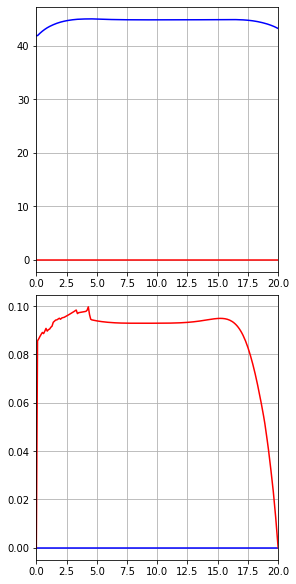

1


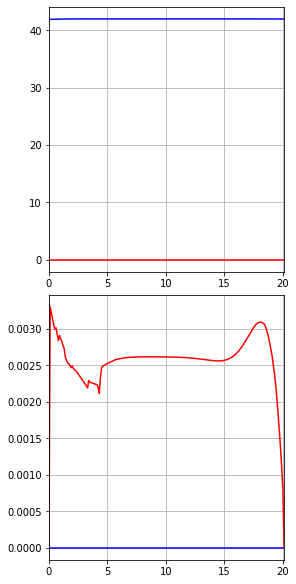

2


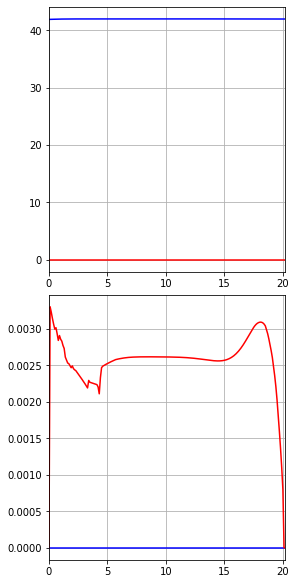

3


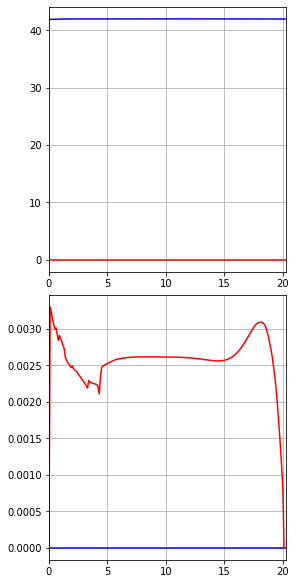

4


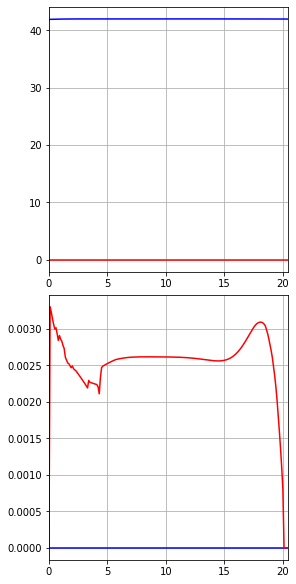

5


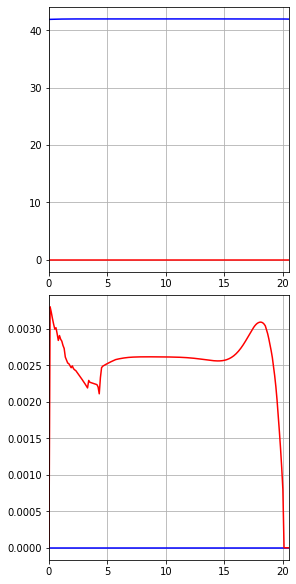

6


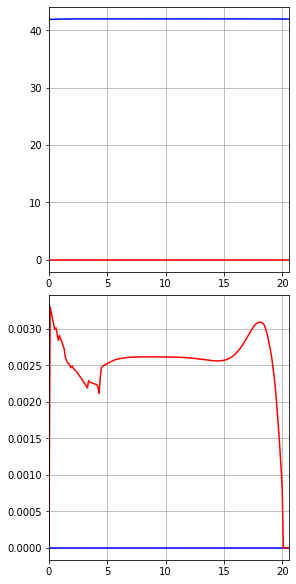

7


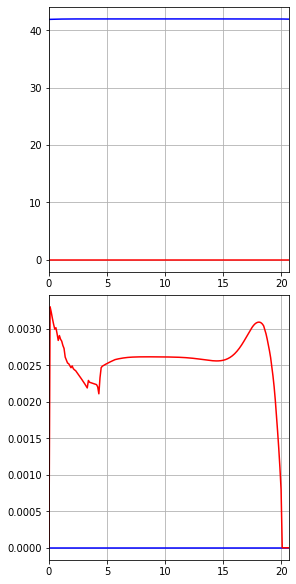

8


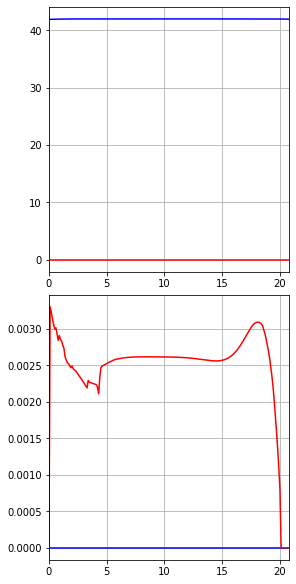

9


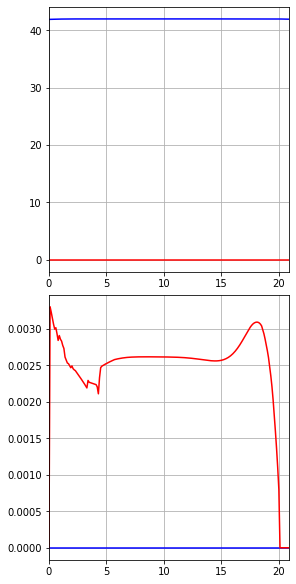

In [282]:
i = 1
for j in range(10):
    print(j)
    
    plot_time_array = np.arange(0.,round(round(d_array[j],1)+aln.params.dt,1),aln.params.dt)

    fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )

    ax[0].plot(plot_time_array, bestState_maxW[i][j][0,0,n_pre-1:-n_post+1], color= 'red')
    ax[0].plot(plot_time_array, bestState_maxW[i][j][0,1,n_pre-1:-n_post+1], color= 'blue')

    ax[1].plot(plot_time_array, bestControl_maxW[i][j][0,0,n_pre-1:-n_post+1], color = 'blue')
    ax[1].plot(plot_time_array, bestControl_maxW[i][j][0,1,n_pre-1:-n_post+1], color = 'red')

    for k in range(2):
        ax[k].set_xlim(0.,d_array[j])
    plt.show()